In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from langdetect import detect


In [3]:

comments_with_posts= pd.read_csv("../data/raw_data/comments_posts_transcripts_raw.csv")

/var/folders/5k/b8_r8jw502n4zztm42zd76m80000gn/T/ipykernel_35406/53980816.py:1: DtypeWarning: Columns (0,4,7,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_with_posts= pd.read_csv("../data/raw_data/comments_posts_transcripts_raw.csv")


NOTE: only 587 of all 60.000 comments are referring to the profile_posts table.
26 comments did not have a matching post_id but that is fine

We do not have a language field in comments, need to check if the one from posts is correct. you can comment in german and an english post eg

In [4]:
comments_with_posts_ger_eng = comments_with_posts[comments_with_posts.textLanguage.isin(['en','de'])]
comments_with_posts_ger_eng

,post_id,text,textLanguage,createTimeISO,isAd,author_nickName,author_signature,author_fans,video_duration,webVideoUrl,...,comment_id,comment_createTimeISO_comment,comment,diggCount_comment,replyCommentTotal_comment,uniqueId_comment,detected_language,transcribed_text,video_description,bucketUrl
0,7324804334678494510,MASQUE VIVANT- The iconic French face mask by ...,en,2024-01-16T21:02:08.000Z,False,ALEXIS LAUREN,"Bespoke facials, injectables & more \n🐚 MIAMI",1444,10.0,https://www.tiktok.com/@alexislaurencollective...,...,7.324830e+18,2024-01-16T22:42:04.000Z,Need her,1.0,0.0,veroscutaro,English,Is it a crime that I still want you.,This video showcases the Biologique Recherche ...,https://storage.cloud.google.com/capstone-soci...
1,7324804334678494510,MASQUE VIVANT- The iconic French face mask by ...,en,2024-01-16T21:02:08.000Z,False,ALEXIS LAUREN,"Bespoke facials, injectables & more \n🐚 MIAMI",1444,10.0,https://www.tiktok.com/@alexislaurencollective...,...,7.324805e+18,2024-01-16T21:04:44.000Z,Heaven ✨,1.0,0.0,myfriendsask,English,Is it a crime that I still want you.,This video showcases the Biologique Recherche ...,https://storage.cloud.google.com/capstone-soci...
4,7470848838174100758,"Teil 1 | Was kann ich euch noch zeigen, wonach...",de,2025-02-13T10:29:16.000Z,False,alina.cosmetics_,"Ich mach das alles nur aus fun, also abonniert...",68800,66.0,https://www.tiktok.com/@alina.cosmetics_/video...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,7436867396570254625,Auch wenn ich nur eine minimale anzahl von per...,de,2024-11-13T20:43:50.000Z,False,ME,fashion|skincare|beauty\n💌dm for Cooperation,2876,53.0,https://www.tiktok.com/@mel1ssae/video/7436867...,...,7.436870e+18,2024-11-13T20:53:48.000Z,Girl wie gut sieht deine Haut jetzt aber aus 😭,15.0,0.0,dzesi_dzesi_,German,wie ich es geschafft habe von diesem Hautbild ...,The woman in this video is discussing how she ...,https://storage.cloud.google.com/capstone-soci...
57,7436867396570254625,Auch wenn ich nur eine minimale anzahl von per...,de,2024-11-13T20:43:50.000Z,False,ME,fashion|skincare|beauty\n💌dm for Cooperation,2876,53.0,https://www.tiktok.com/@mel1ssae/video/7436867...,...,7.437100e+18,2024-11-14T11:45:42.000Z,Wann hat sich deine Haut mit den Tabletten geb...,2.0,1.0,kekdendidofofkfjff,German,wie ich es geschafft habe von diesem Hautbild ...,The woman in this video is discussing how she ...,https://storage.cloud.google.com/capstone-soci...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213898,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,7.486770e+18,2025-03-28T08:10:28.000Z,ASMR makes everything feel so cozy! ❤️So relax...,3.0,0.0,liwayway.iloilo,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google.com/capstone-soci...
213899,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,7.486976e+18,2025-03-28T21:32:43.000Z,you muslim?,0.0,2.0,emirkayraz,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google.com/capstone-soci...
213900,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,7.487743e+18,2025-03-30T23:07:28.000Z,send 3 4 years in dagestan and forget😂,1.0,0.0,thriftyhanaad,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google.com/capstone-soci...
213901,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻

After selecting only German and English 54237 rows compared to the 65619 from before

### Sentiment model

### Sentiment Model Selection

To keep things simple and efficient, we decided to start with a **single multilingual model**, as monolingual models do not significantly outperform them for our use case.

**Models Considered:**

- XLM-RoBERTa (XLM-R)
  - RoBERTa-based model by Facebook supporting 100+ languages.
  - The `cardiffnlp/twitter-xlm-roberta-base-sentiment` variant is fine-tuned on tweets in 8 languages (including English and German).
  - Outputs: *Negative*, *Neutral*, *Positive*.
  
- DistilBERT Multilingual (tabularisai/multilingual-sentiment-analysis)
  - Lightweight transformer supporting 22 languages including English and German.
  - Fine-tuned specifically for sentiment classification.

- nlptown/bert-base-multilingual-uncased-sentiment
  - Predicts star ratings (1–5 stars). Can be mapped as follows:
    - 1–2 stars → Negative  
    - 3 stars → Neutral  
    - 4–5 stars → Positive  

All three perform well on sentiment benchmarks (~85–87% F1), especially for English and German tweets. The performance differences are typically below 5%, making any of them a reliable choice for a neutral/positive/negative classification task.

For lightweight baselines or quick prototypes, options like **VADER (NLTK)**, **TextBlob**, or **Flair NLP** could be used—but they're not suitable for high-quality results.

**Goal**: Choose a model that handles slang, emojis, and informal language well.

In [8]:

# Clean input texts
comments_with_posts_ger_eng = comments_with_posts_ger_eng[
    comments_with_posts_ger_eng["comment"].notnull()
].copy()

# Ensure all values are strings
comments_with_posts_ger_eng["comment"] = comments_with_posts_ger_eng["comment"].astype(str)

# Limit very long texts (optional: you can adjust cutoff)
comments_with_posts_ger_eng["comment"] = comments_with_posts_ger_eng["comment"].apply(lambda x: x[:1000])

# Extract text list
texts = comments_with_posts_ger_eng["comment"].tolist()

# Load pipeline with truncation settings
pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    device=0,  # or -1 for CPU
    batch_size=16,  # smaller batch to reduce memory issues
    truncation=True,
    max_length=512,
)

# Run the pipeline
results = pipe(texts)

# Convert results to DataFrame
sentiment_df = pd.DataFrame([{
    "sentiment": r["label"],
    "confidence": r["score"]
} for r in results])

# Merge back
comments_with_posts_ger_eng = comments_with_posts_ger_eng.reset_index(drop=True)
comments_with_posts_ger_eng[["sentiment", "confidence"]] = sentiment_df


Device set to use mps:0


In [9]:
sentiment_df.to_csv("sentiment_results.csv", index=False)


In [10]:
comments_with_posts_ger_eng[['comment','sentiment','confidence']]

,comment,sentiment,confidence
0,Need her,neutral,0.652222
1,Heaven ✨,positive,0.625328
2,Girl wie gut sieht deine Haut jetzt aber aus 😭,positive,0.855585
3,Wann hat sich deine Haut mit den Tabletten geb...,neutral,0.861149
4,Kauf dir Skin Kapseln da sind alle Nährstoffe ...,neutral,0.740712
...,...,...,...
159482,The Sunna it’s to trim ur moustache not to shave,neutral,0.676287
159483,ASMR makes everything feel so cozy! ❤️So relax...,positive,0.919825
159484,you muslim?,neutral,0.575396
159485,send 3 4 years in dagestan and forget😂,neutral,0.421856


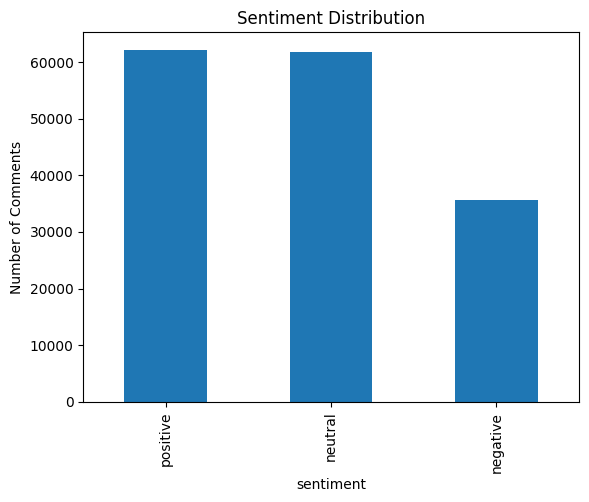

In [11]:
comments_with_posts_ger_eng["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution")
plt.ylabel("Number of Comments")
plt.show()

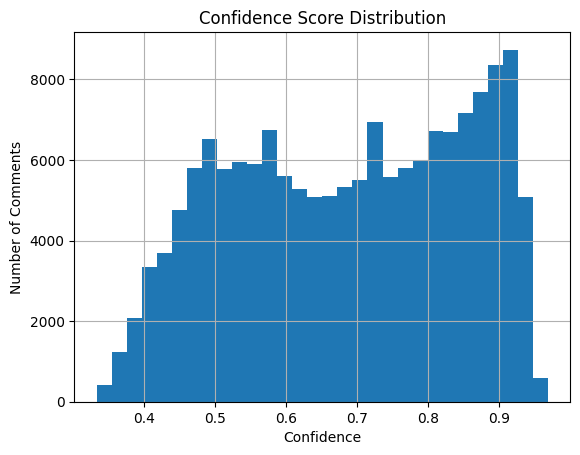

In [12]:
comments_with_posts_ger_eng["confidence"].hist(bins=30)
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Comments")
plt.show()

In [13]:
# Load your sentiment-labeled DataFrame
negative_comments = comments_with_posts_ger_eng[comments_with_posts_ger_eng["sentiment"] == "negative"]['comment']
positive_comments = comments_with_posts_ger_eng[comments_with_posts_ger_eng["sentiment"] == "positive"]['comment']

In [14]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import stopwordsiso as stopwordsiso
from hdbscan import HDBSCAN

negative_comments = [comment for comment in negative_comments if len(comment.split()) > 3] #filter out short comments

# Define supported languages and extra stopwords
langs = ["en", "de", "fr", "es", "pt", "nl"]
extra_stopwords = ["im", "like", "thing", "ok", "got", "youre", "omg", "pls", "tbh", "smh", "ain't"]

# Create a list of all stopwords across languages + custom terms
stopwords_list = list(
    set(word for lang in langs for word in stopwordsiso.stopwords(lang) or [])
    .union(extra_stopwords)
)

In [15]:
# Create custom count vectorizer model
vectorizer_model = CountVectorizer(stop_words=stopwords_list)

hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=4, metric='euclidean')

# Use sentence-transformers model (fast and great for social data)
embedding_model = SentenceTransformer("all-mpnet-base-v2")  #all-MiniLM-L6-v2

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model,language="multilingual")


In [16]:
topics_positive, probs_positive = topic_model.fit_transform(positive_comments)

In [17]:
topics_negative, probs_negative = topic_model.fit_transform(negative_comments)

In [18]:
topic_info = topic_model.get_topic_info()
#-1 are outliers

topic_info.iloc[1]['Representative_Docs']

topic_info
topic_info[topic_info.Topic != -1].sort_values("Count", ascending=False).head(20)


,Topic,Count,Name,Representation,Representative_Docs
1,0,384,0_itu_aja_yang_aku,"[itu, aja, yang, aku, di, beli, ini, nya, ada,...",[mau tanya dongggggg\naku pake g2g yang centel...
2,1,374,1_не_на_это_что,"[не, на, это, что, меня, так, как, от, мне, она]",[если бы у меня было такое то у меня сестрёнка...
3,2,358,2_cara_agua_piel_quiero,"[cara, agua, piel, quiero, dinero, pensé, come...",[Lo quiero intentar pero me da miedo que me sa...
4,3,351,3_ما_من_انا_بنات,"[ما, من, انا, بنات, في, حبوب, مو, وجهي, شي, على]",[بالله عليكي تجاوبيني على سؤالي ايش سر بشرتك ح...
5,4,333,4_toner_toners_milky_recipe,"[toner, toners, milky, recipe, glow, byoma, pa...","[I thought toner was first 🥲, The toner is a n..."
6,5,270,5_money_rich_afford_bank,"[money, rich, afford, bank, poor, cost, broke,...","[your really rich but I,m poor🥺, Omg how much ..."
7,6,255,6_peau_visage_faire_truc,"[peau, visage, faire, truc, eau, calcaire, mas...",[🙏 madame pouvez vous faire une routine pour l...
8,7,255,7_sunscreen_spf_sun_sunscreens,"[sunscreen, spf, sun, sunscreens, sands, bondi...",[what sunscreen is that i cannot find it on yo...
9,8,254,8_hormonal_acne_puberty_started,"[hormonal, acne, puberty, started, diet, clear...","[Some do have hormonal acne…, I need help with..."
10,9,242,9_pake_bta_meri_aku,"[pake, bta, meri, aku, bht, yg, ko, ka, cuma, ...",[aku kira cuma aku yg lama bgt kalo pake skinc...


In [24]:
# 1. Get filtered negative comments used for topic modeling
filtered_negative_comments_df = comments_with_posts_ger_eng[
    (comments_with_posts_ger_eng["sentiment"] == "negative") &
    (comments_with_posts_ger_eng["comment"].apply(lambda x: len(str(x).split()) > 3))
].copy().reset_index(drop=True)

# 2. Make sure the number of rows matches
assert len(filtered_negative_comments_df) == len(topics_negative), \
    f"Expected {len(filtered_negative_comments_df)} == {len(topics_negative)}"

# 3. Assign topic results safely
filtered_negative_comments_df["topic"] = topics_negative
filtered_negative_comments_df["topic_probability"] = probs_negative

# 4. Filter high-confidence topics
negative_comments_df_cleaned = filtered_negative_comments_df[
    (filtered_negative_comments_df["topic"] != -1) &
    (filtered_negative_comments_df["topic_probability"] > 0.7)
]

# 5. View or save
negative_comments_df_cleaned


,post_id,text,textLanguage,createTimeISO,isAd,author_nickName,author_signature,author_fans,video_duration,webVideoUrl,...,replyCommentTotal_comment,uniqueId_comment,detected_language,transcribed_text,video_description,bucketUrl,sentiment,confidence,topic,topic_probability
1,7436867396570254625,Auch wenn ich nur eine minimale anzahl von per...,de,2024-11-13T20:43:50.000Z,False,ME,fashion|skincare|beauty\n💌dm for Cooperation,2876,53.0,https://www.tiktok.com/@mel1ssae/video/7436867...,...,2.0,nidakar_,German,wie ich es geschafft habe von diesem Hautbild ...,The woman in this video is discussing how she ...,https://storage.cloud.google.com/capstone-soci...,negative,0.683452,572,1.000000
3,7359927067971947808,Hydrafacial ASMR 🙌🏽 #kosmetiksalon #salon #ko...,en,2024-04-20T12:36:02.000Z,False,EROYAL_beauty,EROYAL beauty & more\nInstagram: @eroyal_beauty,1319,15.0,https://www.tiktok.com/@eroyal_beauty/video/73...,...,0.0,cxx1141,Unknown,[No speech],A esthetician wearing black gloves performs a ...,https://storage.cloud.google.com/capstone-soci...,negative,0.514304,51,1.000000
4,7478553696293440823,a game changer skincare!🍃 @IUNIK Indonesia #i...,en,2025-03-06T04:48:06.000Z,False,Clarice 🤍,Actress Model Beauty Specialist Lifestyle & Tr...,1200000,54.0,https://www.tiktok.com/@clariceecutie/video/74...,...,1.0,chiropapa77,Indonesian,"I finally found this new brand, and it's a tot...",Check out this video to learn more about this ...,https://storage.cloud.google.com/capstone-soci...,negative,0.406823,0,1.000000
10,7425372280122920222,the cutest miniature makeup haul 💄🛍️ #minimake...,en,2024-10-13T21:17:07.000Z,False,grace hewitt,home & lifestyle\n🫧💐🥂\n\ngracelynnhewitt@palet...,793300,88.0,https://www.tiktok.com/@gracelynnhewitt99/vide...,...,0.0,gracel13135478_3,English,[Music],Enjoy this mini makeup and skincare haul. In t...,https://storage.cloud.google.com/capstone-soci...,negative,0.821371,271,1.000000
12,7426007768923999521,"So ein Ergebnis nach drei Wochen! Achtung, bev...",de,2024-10-15T14:22:58.000Z,False,Sanna ☀️❤️‍🔥,La Familia❤️‍🔥\nDie Frau mit🔥 \nSonne☀️im Herz...,9907,120.0,https://www.tiktok.com/@8_sanna_8/video/742600...,...,1.0,thomaslotharhoffm,German,Du gedacht dass Rizinusöl deine geplatzten Äde...,In diesem Video spricht die Dame über die Wirk...,https://storage.cloud.google.com/capstone-soci...,negative,0.797790,521,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31406,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,6.0,dozz_77,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google.com/capstone-soci...,negative,0.929678,172,1.000000
31408,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,8.0,gaygay52728282,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google.com/capstone-soci...,negative,0.791565,53,1.000000
31409,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,2.0,user_m305_305,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google.com/capstone-soci...,negative,0.445088,3,1.000000
31411,7486564456743308546,Beard & Skincare ASMR Pflege für Bart & Haut!...,de,2025-03-27T18:53:44.000Z,False,lifeofogaa,Lifestyle 💆🏻‍♂️ | Vlogs 🎥 | Married 💍\n📩 lifeo...,206900,60.0,https://www.tiktok.com/@lifeofogaa/video/74865...,...,0.0,khtyp1,English,[Music],Watch a man as he trims his beard in this ASMR...,https://storage.cloud.google

- 4: oily skin
- 5: pores
- 6: acne
- 8: face mask, mouth tape, ears?
- 9: rice
- 12: oil cleanser
- 13: sunscreen
- 14: body hair
- 15: toner
- 17: expensive
- 19: asking for products
- 20: Korean, Asian, American skincare

In [25]:
positive_comments_df = comments_with_posts_ger_eng[comments_with_posts_ger_eng["sentiment"] == "positive"]
positive_comments_df["topic"] = topics_positive
positive_comments_df["topic_probability"] = probs_positive

positive_comments_df_cleaned = positive_comments_df[
    (positive_comments_df["topic"] != -1) &
    (positive_comments_df["topic_probability"] > 0.7)
]

positive_comments_df_cleaned[["comment", "topic","topic_probability" ]]

,comment,topic,topic_probability
1,Heaven ✨,1019,1.000000
20,probiotika hat mich gerettet,1042,1.000000
24,😍😍😍😍,0,1.000000
25,Sehr gut 👍,23,0.908605
27,"we would love to have you as our ambassador , ...",259,0.964436
...,...,...,...
159436,👍,0,0.870766
159450,دعوشي كيوتت,1,1.000000
159455,"I feel so at ease after watching ASMR, it’s li...",233,1.000000
159456,ياعلي إبن أبي طالب,1,1.000000


In [26]:
positive_comments_df_cleaned[positive_comments_df_cleaned["topic"] == 3][["comment", "topic"]].head(20)

,comment,topic
561,гузалим результаты 🥰🥰🥰,3
1745,лана я тебя люблю очень,3
1761,"Лана,ответьте на мой коммент, тогда я вас буду...",3
1765,такая чистая и блестящая кожа...😍,3
1975,красива,3
2093,у меня такие есть😭🙏🙏,3
2096,спокойной ночи,3
2113,приятного аппетита,3
3500,звуки из h2o просто добавь воды🥰😻,3
5438,я готова смотреть это бесконечно,3


**Positive comments - Interesting clusters**

- 3: love for korean skincare
- 8: routine
- 11: people buy the product
- 12: need to try this
- 18: no makeup
- 20: sunscreen

In [27]:
def prepare_weekly_topic_trends(df, date_col="createTimeISO", post_col="post_id", topic_col="topic", min_posts=5):
    """
    Prepares normalized topic trends by week (comments per post).

    Parameters:
        df (pd.DataFrame): Input DataFrame with date, post_id, and topic columns.
        date_col (str): Column name for datetime info.
        post_col (str): Column name for the post identifier.
        topic_col (str): Column name for topic labels.
        min_posts (int): Minimum number of posts per week to keep the week.

    Returns:
        pd.DataFrame: Weekly topic trends with normalized comment counts.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Weekly topic comment counts
    topic_counts = (
        df
        .groupby([df[date_col].dt.to_period("W"), df[topic_col]])
        .size()
        .reset_index(name="comment_count")
    )

    # Weekly post counts
    post_counts = (
        df
        .groupby(df[date_col].dt.to_period("W"))[post_col]
        .nunique()
        .reset_index(name="post_count")
    )

    # Merge & normalize
    topic_over_time = topic_counts.merge(post_counts, on=date_col)
    topic_over_time["comments_per_post"] = topic_over_time["comment_count"] / topic_over_time["post_count"]

    # Convert Period to Timestamp
    topic_over_time[date_col] = topic_over_time[date_col].dt.to_timestamp()

    # Filter out weeks with very few posts
    topic_over_time = topic_over_time[topic_over_time["post_count"] >= min_posts]

    return topic_over_time

In [28]:
topic_trends_positive = prepare_weekly_topic_trends(positive_comments_df_cleaned)
topic_trends_negative = prepare_weekly_topic_trends(negative_comments_df_cleaned)

In [29]:
def plot_smoothed_topics(
    df,
    topic_names,
    start_date="2024-04-01",
    window=3,
    figsize=(12, 6),
    title="Normalized Topic Trends Since April 2024"
):
    """
    Plots smoothed topic trends over time using a rolling average.

    Parameters:
        df (pd.DataFrame): The output of prepare_weekly_topic_trends().
        topic_names (dict): Mapping of topic ID to display names.
        start_date (str or pd.Timestamp): Date to start plotting from.
        window (int): Rolling window size for smoothing.
        figsize (tuple): Size of the plot.
        title (str): Title of the plot.
    """
    start_date = pd.to_datetime(start_date)
    selected_topics = list(topic_names.keys())

    # Filter data
    topic_over_time = df[
        (df["createTimeISO"] >= start_date) &
        (df["topic"].isin(selected_topics))
    ]

    # Plot
    plt.figure(figsize=figsize)
    for topic in selected_topics:
        data = topic_over_time[topic_over_time["topic"] == topic].copy()

        # Apply rolling average
        data["smoothed"] = data["comments_per_post"].rolling(window=window, min_periods=1).mean()

        plt.plot(data["createTimeISO"], data["smoothed"], label=topic_names[topic])

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Avg Comments per Post")
    plt.legend(title="Topic")
    plt.tight_layout()
    plt.show()


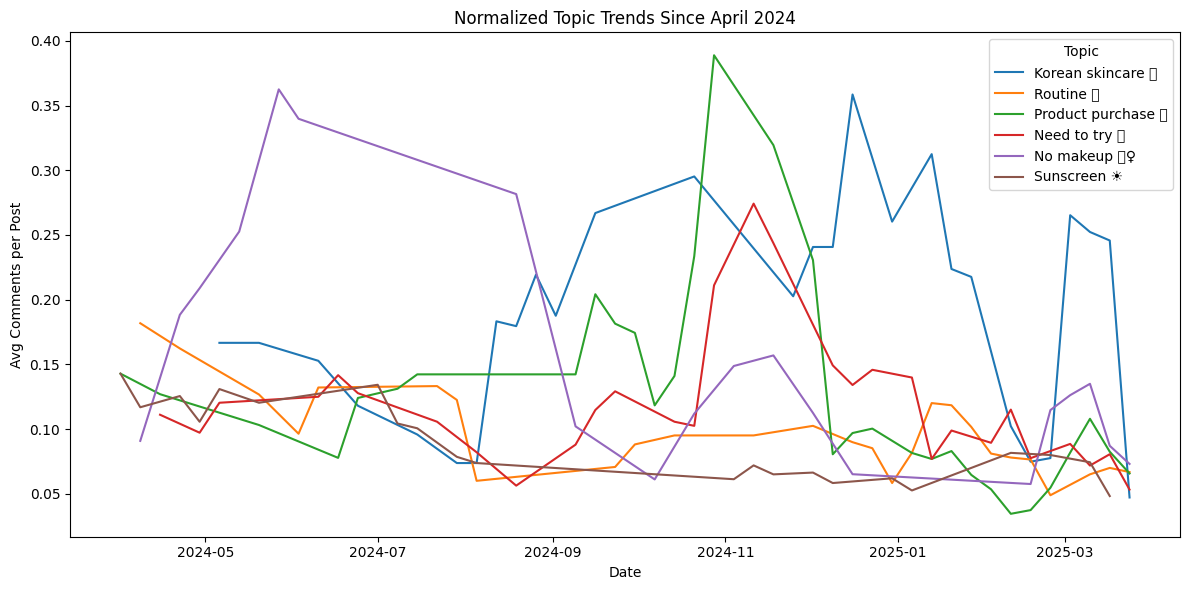

In [ ]:
topic_names = {
    3: "Korean skincare 💕",
    8: "Routine 🔁",
    11: "Product purchase 🛍️",
    12: "Need to try 🌟",
    18: "No makeup 🧖‍♀️",
    20: "Sunscreen ☀️"
}

plot_smoothed_topics(
    df=topic_trends_positive,
    topic_names=topic_names,
    window=3  # 3-week smoothing
)

In [ ]:
topic_names = {
    3: "Korean skincare 💕",
    4: "Oily skin 😓",
    5: "Pores 🔬",
    6: "Acne breakouts 😬",
    8: "Face mask / Mouth tape / Ears? 😷🩹",
    9: "Rice skincare 🌾",
    12: "Oil cleanser 🧴",
    13: "Sunscreen ☀️",
    14: "Body hair care 🪒",
    15: "Toner routine 💧",
    17: "Too expensive 💸",
    18: "No makeup 🧖‍♀️",
    20: "Skincare by region 🌍 (Korean/Asian/American)"
}

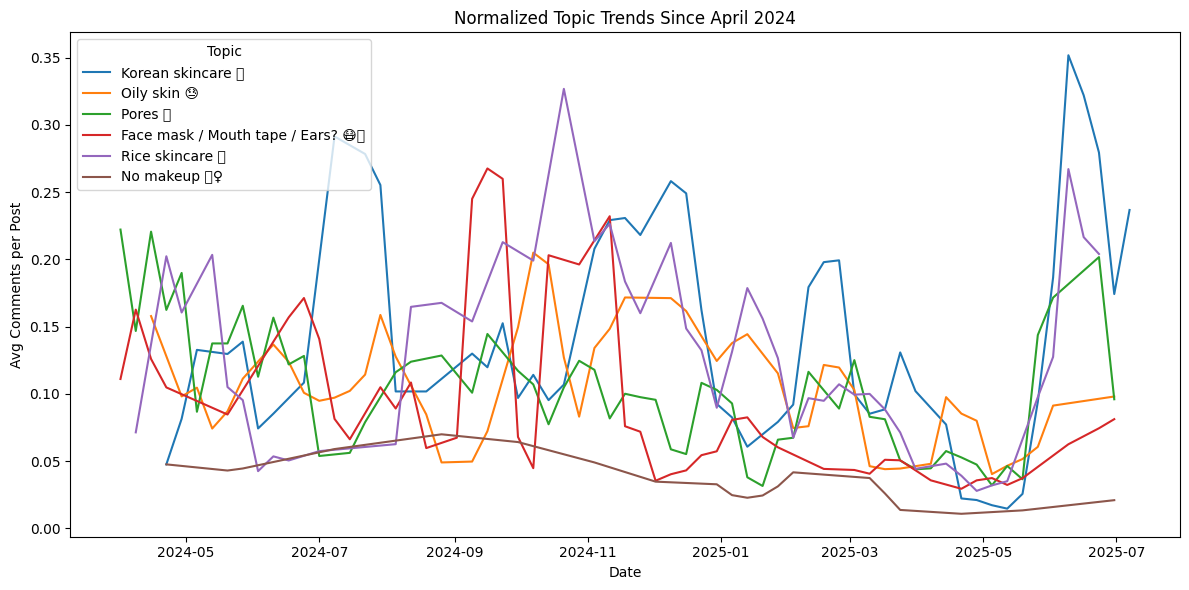

In [30]:
topic_names = {
    3: "Korean skincare 💕",
    4: "Oily skin 😓",
    5: "Pores 🔬",
    8: "Face mask / Mouth tape / Ears? 😷🩹",
    9: "Rice skincare 🌾",
    18: "No makeup 🧖‍♀️",
}

plot_smoothed_topics(
    df=topic_trends_negative,
    topic_names=topic_names,
    window=3  # 3-week smoothing
)